In [ ]:
%pip install -U lightgbm==3.3.2

In [ ]:
%pip install implicit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [ ]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/HM-new/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [ ]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [ ]:
data_dir = Path("/content/drive/MyDrive/HM-new/data/")
model_dir = Path("/content/drive/MyDrive/HM-new/models/")

In [ ]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "pivot"
TEST = True # * Set as `False` when do local experiments to save time

In [ ]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [ ]:
dh = DataHelper(data_dir)

In [ ]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [ ]:
data = dh.load_data(name="encoded_full")

In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
# * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 
if TEST:
    week = 0
    trans = data["inter"]
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=15, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=20.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=2),
            TimeHistory(customer_list, last_week, n=9, name='1'),
            TimeHistory(customer_list, last_3days, n=16, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=12, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=8, name='2'),
            SaleTrend(customer_list, train, days=7, n=2),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )
    
    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
del train, valid, last_week, customer_list, candidates
gc.collect()

## Feature engineering


In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
# merge full candidates to transaction data (avoid feature missing in training data)
full_candidates = []
for i in tqdm(range(WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    full_candidates += candidate['article_id'].values.tolist()
full_candidates = list(set(full_candidates))
del candidate
gc.collect()

num_candidates = len(full_candidates)
full_candidates = np.array(full_candidates)
full_candidates = np.tile(full_candidates, WEEK_NUM + 1)
weeks = np.repeat(np.arange(1,WEEK_NUM+2), num_candidates)
full_candidates = pd.DataFrame({'article_id':full_candidates, 'week':weeks})

inter['valid'] = 1
in_train = inter[inter['week']<=WEEK_NUM + 1]
out_train = inter[inter['week']>WEEK_NUM + 1]

in_train = in_train.merge(full_candidates, on=['article_id','week'], how='right')
in_train['valid'] = in_train['valid'].fillna(0)
inter = pd.concat([in_train, out_train], ignore_index=True)
inter = inter.sort_values(["valid"], ascending=False).reset_index(drop=True)

100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


17

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
inter.shape

(31837313, 8)

In [ ]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
1+1

2

In [ ]:
inter.shape

(31837313, 18)

In [ ]:
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
inter.shape

(31837313, 30)

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'], week_num=WEEK_NUM)

100%|██████████| 6/6 [02:00<00:00, 20.07s/it]


In [ ]:
inter.shape

(31837313, 32)

In [ ]:
inter, _ = reduce_mem_usage(inter)

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"], week_num=WEEK_NUM)
inter["p_sale"] = week_sale(inter, ["product_code"], week_num=WEEK_NUM)
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True, week_num=WEEK_NUM)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True, week_num=WEEK_NUM)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1, week_num=WEEK_NUM) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1, week_num=WEEK_NUM)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1, week_num=WEEK_NUM)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1, week_num=WEEK_NUM)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    # "product_group_name",
    # "graphical_appearance_no",
    # "colour_group_code",
    # "perceived_colour_value_id",
    # "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale", week_num=WEEK_NUM)
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1, week_num=WEEK_NUM)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

100%|██████████| 1/1 [00:22<00:00, 22.43s/it]


In [ ]:
inter.shape

(31837313, 54)

In [ ]:
# * Date related
curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(100)}
current_dat = inter['week'].map(curr_date_dict)
mask = inter['valid']==0
inter.loc[mask, 't_dat'] = inter.loc[mask, 'week'].map(curr_date_dict)
first_date = inter.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
# last_date = inter.groupby('article_id')['t_dat'].max().reset_index(name='last_dat')
inter = pd.merge(inter, first_date, on='article_id', how='left')
# df = pd.merge(df, last_date, on='article_id', how='left')
inter['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(inter['first_dat'])).dt.days
# df['last_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(df['last_dat'])).dt.days

In [ ]:
inter.shape

(31837313, 55)

In [ ]:
inter['i_full_sale'] = full_sale(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_full_sale'] = full_sale(inter, ['product_code'], week_num=WEEK_NUM)

inter['i_daily_sale'] = inter['i_full_sale'] / inter['first_dat']
inter['p_daily_sale'] = inter['p_full_sale'] / inter['first_dat']
inter['i_daily_sale_ratio'] = inter['i_daily_sale'] / inter['p_daily_sale']
inter['i_w_full_sale_ratio'] = inter['i_sale'] / inter['i_full_sale']

inter['i_2w_full_sale_ratio'] = inter['i_2w_sale'] / inter['i_full_sale']
inter['p_w_full_sale_ratio'] = inter['p_sale'] / inter['p_full_sale']
inter['p_2w_full_sale_ratio'] = inter['p_2w_sale'] / inter['p_full_sale']

inter['i_week_above_daily_sale'] = inter['i_sale'] / 7 - inter['i_daily_sale']
inter['p_week_above_full_sale'] = inter['p_sale'] / 7 - inter['i_full_sale']
inter['i_2w_week_above_daily_sale'] = inter['i_2w_sale'] / 14 - inter['i_daily_sale']
inter['p_2w_week_above_daily_sale'] = inter['p_2w_sale'] / 14 - inter['p_daily_sale']

In [ ]:
gc.collect()

94

In [ ]:
for f in tqdm(item_feats):
    inter[f'{f}_full_sale'] = full_sale(inter, [f], week_num=WEEK_NUM)
    f_first_date = inter.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
    inter = inter.merge(f_first_date, on=f, how='left')
    inter[f'{f}_daily_sale'] = inter[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(inter[f'{f}_first_dat'])).dt.days
    inter[f'i_{f}_daily_sale_ratio'] = inter['i_daily_sale'] / inter[f'{f}_daily_sale']
    inter[f'p_{f}_daily_sale_ratio'] = inter['p_daily_sale'] / inter[f'{f}_daily_sale']
    del inter[f'{f}_full_sale'], inter[f'{f}_first_dat']
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

17

100%|██████████| 1/1 [01:21<00:00, 81.40s/it]


In [ ]:
for f in item_feats + ['i_full_sale','p_full_sale']:
    del inter[f]

In [ ]:
gc.collect()

100

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

In [ ]:
inter.shape

(31837313, 70)

In [ ]:
inter = inter.loc[inter['week'] <= WEEK_NUM + 2]

In [ ]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
inter = inter[inter['week'] <= WEEK_NUM + 2]
# data["inter"] = inter

In [ ]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

KeyboardInterrupt: ignored

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
gc.collect()

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        # tmpl = []
        for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
            # * merge features
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            print(f"Chunk {chunk} done...")
            # tmpl.append(sub_candidate)
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

## Ranking


In [ ]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")    

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 18.41it/s]


In [ ]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


In [ ]:
for f in tqdm(feats):
    for i in range(1,WEEK_NUM):
        if f in candidates[i].columns and candidates[i][f].dtype == 'float':
            candidates[i][f] = candidates[i][f].astype('float16')

100%|██████████| 99/99 [00:01<00:00, 80.52it/s] 


In [ ]:
gc.collect()

65

### Train


In [ ]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth": 4,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    ""
    # 'device':'gpu'
}

In [ ]:
# * some rules are skipped for some weeks, we need to concat them together
# * to merge the columns
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)
# for i in tqdm(range(2,WEEK_NUM)):
#     for f in feats:
#         if f not in candidates[i].columns:
#             candidates[i][f] = np.nan

In [ ]:
# # New Feature
# first_date = data['inter'].groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
# curr_date_dict = {x:calc_valid_date(x)[0] for x in range(1, WEEK_NUM)}
# current_dat = full_data['week'].map(curr_date_dict)
# full_data = pd.merge(full_data, first_date, on='article_id', how='left')
# full_data['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(full_data['first_dat'])).dt.days

# feats.append('first_dat')

In [ ]:
# for f in ["i_sale", "p_sale", "i_sale_uni", "p_sale_uni"]:
#     full_data[f"{f}_day_sale"] = full_data[f] / full_data["first_dat"]
#     feats.append(f"{f}_day_sale")

In [ ]:
def train_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]
    train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(
        drop=True
    )
    valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

    train_group = train[["customer_id", "article_id", "week"]]
    train_group = train_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    train_group = (
        train_group.groupby(["week", "customer_id"])["article_id"].count().values
    )

    valid_group = valid[["customer_id", "article_id"]]
    valid_group = valid_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
def train_binary_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]

    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week


    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
# for i in candidates:
#     print(i,candidates[i]['week'].unique())

In [ ]:
# train = pd.concat([candidates[i] for i in range(2,WEEK_NUM)],ignore_index=True)
# valid = candidates[1]

In [ ]:
# train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(
#     drop=True
# )
# valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [ ]:
# ranker = train_model(train, valid)

In [ ]:
ranker = train_model(full_data, 1, 4) # 4-week 0.853142  0.851841
# ranker = train_binary_model(full_data, 1, 4)# 0.709413

# 0.853642
# 0.853926

# 0.853055

# 0.829717
# 0.828842
# 0.829284

Validating week: 1
Train positive rate: 0.0067018773363074985
Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.827021
[20]	valid_0's map@12: 0.827532
[30]	valid_0's map@12: 0.827805
[40]	valid_0's map@12: 0.828106
[50]	valid_0's map@12: 0.828383
[60]	valid_0's map@12: 0.828418
[70]	valid_0's map@12: 0.828974
[80]	valid_0's map@12: 0.829075
[90]	valid_0's map@12: 0.829131
[100]	valid_0's map@12: 0.82908
[110]	valid_0's map@12: 0.829106
[120]	valid_0's map@12: 0.82913
[130]	valid_0's map@12: 0.829143
[140]	valid_0's map@12: 0.829223
[150]	valid_0's map@12: 0.829159
[160]	valid_0's map@12: 0.829242
[170]	valid_0's map@12: 0.829322
[180]	valid_0's map@12: 0.829362
[190]	valid_0's map@12: 0.829404
[200]	valid_0's map@12: 0.829377
[210]	valid_0's map@12: 0.829437
Early stopping, best iteration is:
[188]	valid_0's map@12: 0.829548


### Inference

In [ ]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_1.model")

<Figure size 576x1584 with 0 Axes>

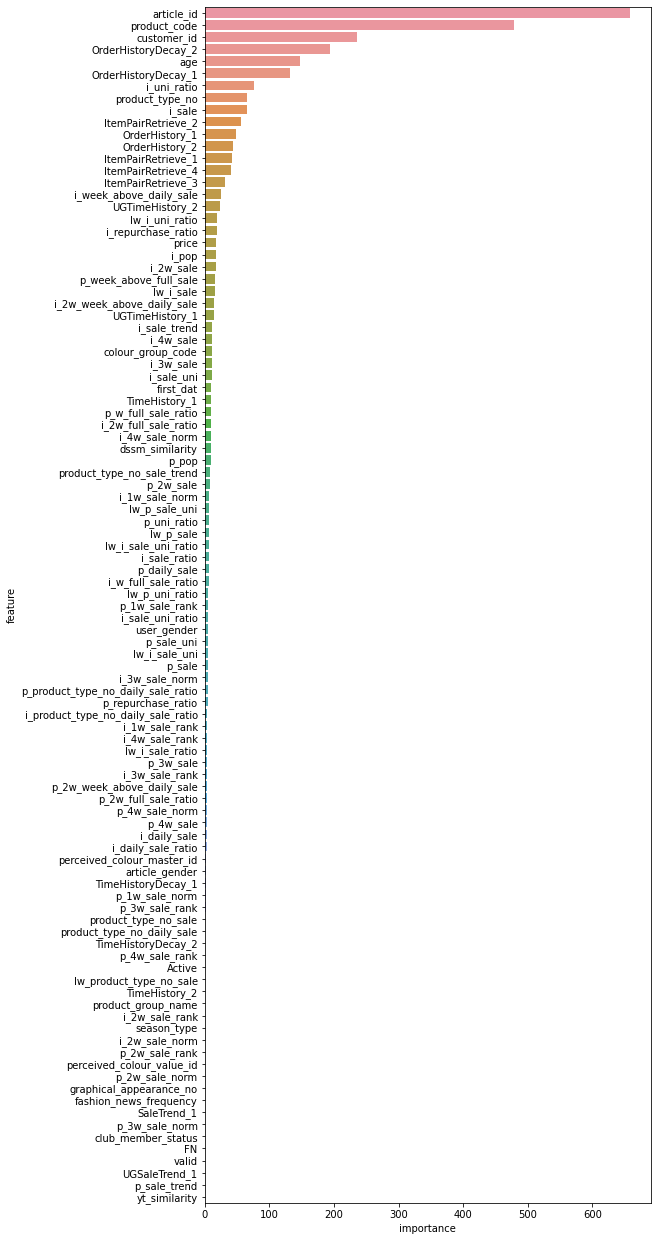

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 22))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = full_data[full_data["week"] == 1].reset_index(drop=True)# valid.reset_index(drop=True) # 

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

100%|██████████| 68984/68984 [00:05<00:00, 12367.17it/s]


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week min_pos_rate 0.006 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

# 0.029035548891779315 LB:0.0267+
# 0.02936299322497085 LB:0.0272 binary: 0.02875858467034642

# 0.02934790456627846
# 0.029538123693645727 first_date

# 0.02971730505701681
# 0.02927408233544082

# 0.027985174525317645

# 0.0294
# 0.029623859943538937

# 0.029580230369399857   0.029128021524487725

0.029580230369399857

In [ ]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"rank_valid.pqt")

---

In [ ]:
pred_rank = pd.read_parquet(data_dir/"processed"/"rank_valid.pqt")
pred_binary = pd.read_parquet(data_dir/"processed"/"binary_valid.pqt")
pred_nn = pd.read_parquet(data_dir/"processed"/"nn_valid.pqt")
pred_nn.rename(columns={'article_id':'prediction'},inplace=True)

In [ ]:
# pred_rank = pred_rank.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred_binary = pred_binary.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred_nn = pred_nn.sort_values(by='prob', ascending=False).reset_index(drop=True)

In [ ]:
# pred_rank['prob'] = (pred_rank['prob'] - pred_rank['prob'].min()) / (pred_rank['prob'].max() - pred_rank['prob'].min())
# pred_binary['prob'] = (pred_binary['prob'] - pred_binary['prob'].min()) / (pred_binary['prob'].max() - pred_binary['prob'].min())

pred = pred_nn.merge(pred_binary, on=['customer_id','prediction'], how='left')
pred['score'] = pred['prob_x'] + pred['prob_y']

pred = pred.sort_values(by='score', ascending=False).reset_index(drop=True)
pred = pred.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 68984/68984 [00:01<00:00, 37511.45it/s]


In [ ]:
# # pred_rank = pred_rank.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
# pred_binary = pred_binary.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
# pred_nn = pred_nn.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

# # pred_rank.rename(columns={'prediction':'rank'},inplace=True)
# pred_binary.rename(columns={'prediction':'binary'},inplace=True)
# pred_nn.rename(columns={'prediction':'nn'},inplace=True)
# pred = pred_nn.merge(pred_binary, on=['customer_id'], how='left')

In [ ]:
def cust_blend(dt, W = [1,1]):
    #Global ensemble weights
    #W = [1.15,0.95,0.85]

    #Create a list of all model predictions
    REC = []

    # Second Try
    REC.append(dt['nn'])
    REC.append(dt['binary'])

    #Create a dictionary of items recommended.
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, v in enumerate(REC[M]):
            if v in res:
                res[v] += (W[M]/(n+1))
            else:
                res[v] = (W[M]/(n+1))

    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

    # Return the top 12 items only
    return res[:12]

In [ ]:
# pred['prediction'] = pred.apply(cust_blend, W = [1.0, 1.0], axis=1)

In [ ]:
pred.head()

,customer_id,prediction
0,81,"[42130, 74, 67523, 104046, 103797, 44033, 1037..."
1,87,"[100229, 27906, 98607, 33869, 53893, 104210, 1..."
2,108,"[13043, 2220, 61306, 61304, 61305, 53893, 5389..."
3,118,"[103794, 3092, 104046, 104073, 56695, 103797, ..."
4,180,"[105181, 104987, 95217, 103794, 3511, 104073, ..."


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

0.032128785732101955

### Test

In [ ]:
del full_data, val_candidates, candidates
gc.collect()

100

In [ ]:
test_pred = []
for chunk in range(2):
    print(f"Chunk {chunk}")
    test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week0_candidate_{chunk}.pqt")
    for feat in cat_features:
        test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])
    batch_size = 5_000_000
    probs = np.zeros(test_candidates.shape[0])
    for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
        outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    test_candidates["prob"] = probs
    pred_lgb = test_candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    test_pred.append(pred_lgb)

Chunk 0


100%|██████████| 6/6 [01:22<00:00, 13.73s/it]


Chunk 1


100%|██████████| 6/6 [01:25<00:00, 14.33s/it]


In [ ]:
pred_lgb = pd.concat(test_pred, ignore_index=True)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"rank_test.pqt")

---

In [ ]:
# pred_lgb = pd.read_parquet(data_dir/"processed"/"binary_test.pqt")
# pred_nn = pd.read_parquet(data_dir/"processed"/"nn_test.pqt")

In [ ]:
# pred_lgb = pred_lgb.merge(pred_nn, on=["customer_id",'prediction'], how="left")

In [ ]:
# pred_lgb['prob'] = pred_lgb['prob_x'] + pred_lgb['prob_y'] # 
# pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)

In [ ]:
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
test_pred = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [01:51<00:00, 12255.95it/s]


In [ ]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [ ]:
def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [ ]:
test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))

100%|██████████| 1371980/1371980 [00:23<00:00, 57174.63it/s]


In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
del submission['prediction']
submission = submission.merge(test_pred, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0779781015 0918522001 0858856005 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0448509014 0918292001 0751471001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0685813001 0918522001 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918522001 0673677002 0751471001 0751471043 05...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0791587001 0852584001 0927530006 07...


### Submit

In [ ]:
submit_msg = "lgb with new sale features and valid leak resolved, CV:0.029580230369399857"

In [ ]:
submit_msg

'lgb with new sale features and valid leak resolved, CV:0.029580230369399857'

In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/HM-new/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%pip install kaggle

In [ ]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f ./submission.csv -m 'lgb with new sale features and valid leak resolved, CV:0.029580230369399857'

100% 258M/258M [00:03<00:00, 87.1MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations